### 0.0 Load dependencies & functions

In [ ]:
import re
from typing import List, Tuple

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import fasttext
from bs4 import BeautifulSoup
from huggingface_hub import hf_hub_download
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def subplot_histograms(
        df: pd.DataFrame,
        main_title: str,
        list_of_titles: List[str],
        xlabels,
        list_of_colors: List[str]
    ):
    """
    This creates histogram subplots for each rating (1-5).
    Each subplot represents the distribution of the dates at which the reviews were written.

    ### Arguments
    - `df`: The input dataframe. It must have a `score` and `at` column.
    - `main_title`: The title of the chart generated.
    - `list_of_titles`: A list of titles e.g., '4-Star Rating','5-Star Rating', etc.
    - `xlabels`: The x-axis label of the chart.
    - `list_of_colors`: A list of color palette codes to use.
    """
    df = df.copy() # best practice to ensure we don't alter the original dataframe

    fig, ax = plt.subplots(5, 1, figsize=(8,10), sharex=True, sharey=True)
    for i in range(5):
        ax[i].hist(df[df['score']==(i+1)]['at'], bins=50, color=list_of_colors[i])
        ax[i].set_title(list_of_titles[i], weight='bold')
        ax[i].set_xlabel(xlabels)
        ax[i].set_ylabel('Frequency')
    fig.suptitle(main_title, fontsize=15, weight='bold')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

In [3]:
def plot_wordcloud(
        target: int,
        title: str,
        df: pd.DataFrame,
        text_col_in_df: str,
        max_words: int = 50,
    ):
    """
    This is a function to plot a wordcloud of the most frequently occurring 
    words based on whether the review is negative (1) or positive (0).

    ### Arguments
    - `target`: Whether the review is negative (1) or positive (0).
    - `title`: The title of the WordCloud chart generated.
    - `df`: The input dataframe. It must have a `content` column.
    - `text_col_in_df`: The text column in the input dataframe.
    - `max_words`: The maximum no. of words in the wordcloud.
    """
    df = df.copy() # best practice to ensure we don't alter the original dataframe
    
    text = df[df['target']==target][text_col_in_df] 

    wordcloud = WordCloud(width=2000, 
                          height=1000, 
                          background_color='white', 
                          max_words=max_words,
                          stopwords=STOPWORDS
                ).generate(' '.join(text)) # Remove stopwords
    
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=15, weight='bold')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # Removes the axis
    plt.tight_layout()

In [4]:
def barplot_cvec(
        df: pd.DataFrame,
        target: int,
        titles: List[str],
        color: str,
        xlimit: Tuple[int, int]
    ):
    """
    Plots top 20 uni-grams and bi-grams for positive and negative reviews.
    
    ### Arguments
    - `df`: The input dataframe
    - `target`: Whether the review is negative (1) or positive (0).
    - `title`: A list of titles 
    - `color`: Color palette to use for charts.
    - `xlimit`: Horizontal axis limits
    """
    df = df.copy() # best practice to ensure we don't alter the original dataframe
    
    words_series = df[df['target']==target]['content_stem']
    
    fig, ax = plt.subplots(1, 2, figsize=(25,12))
    
    ngram = [(1,1),(2,2)] # The ngrams that we would like to plot
    
    for i in range(2):
            
        # Use CountVectorizer to tokenize the text, 
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram[i])

        # Save the tokens in a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names_out())
        sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        # Adjust plot aesthetics
        ax[i].set_title(titles[i], size=25, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit) # Setting a limit so that the barplots are comparable
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

    plt.tight_layout()

In [5]:
def stem_text(
        raw_text: str,
        stopwords_list: List[str] = [],
    ) -> str:
    """
    This is a function to convert raw text to a string of meaningful words.

    ### Arguments
    - `raw_text`: The input text to pre-process.
    - `stopwords_list`: A list of stopwords to be added in the stopwords list.

    ### Returns
    A pre-processed string.
    """
  
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Searching through a set is faster than searching through a list 
    # Hence, we will convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # Adding on stopwords that were appearing frequently in both positive and negative reviews 
    stops.update(stopwords_list)
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
        
    # Instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]        
   
    # Join words back into one string, with a space in between each word
    return(" ".join(meaningful_words))

In [30]:
# download stopwords for NLTK
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faiq0913/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# !python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
# load dataset
reviews = pd.read_csv('../data/genshin_impact_reviews_v03112024.csv', parse_dates=['at','repliedAt'])

### 1.0 Data Cleaning & Pre-processing

#### 1.1 Create a target variable

The goal is to classify positive and negative app reviews. Negative reviews can reveal critical features that are missing from Genshin Impact's app or even bring to light the presence of bugs on the app. This will require immediate action from Hoyoverse. As such, priority will be placed on the prediction of negative sentiment. We will assign the negative reviews (scores 1-3) to class 1, and the positive reviews (scores 4-5) to class 0.

In [8]:
# Defining the target variable using scores
reviews['target'] = reviews['score'].map(lambda x: 1 if x < 4 else 0)

In [9]:
# Check the count of our target variable
reviews['target'].value_counts()

target
1    5194
0    3655
Name: count, dtype: int64

In [10]:
reviews.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id,target
0,9ebbaa68-df60-45ce-bd37-634ed84c4246,Konuchi A,https://play-lh.googleusercontent.com/a-/ALV-U...,Controller doesn't work. Game is unplayable. T...,1,15,5.0.0_26041933_26161852,2024-11-01 18:13:52,We sincerely apologize for your unsatisfactory...,2024-10-22 14:15:18,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1
1,12b832b8-a76a-4292-a916-cbda39384153,BAI Li,https://play-lh.googleusercontent.com/a-/ALV-U...,I've been playing this game for about two year...,1,539,5.0.0_26041933_26161852,2024-09-29 18:04:07,We sincerely apologize for your unsatisfactory...,2024-09-30 16:43:34,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1
2,7f339f1c-a3ac-46ab-95b1-7a2991476824,Tahlia Tucker,https://play-lh.googleusercontent.com/a-/ALV-U...,The rating I could just give is a 1 since I ca...,1,23,5.0.0_26041933_26161852,2024-09-19 06:09:10,We sincerely apologize for your unsatisfactory...,2024-09-25 19:04:25,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1


#### 1.2 Pre-processing

Prior to pre-processing, let's find frequently occurring words in both positive and negative sentiments. This can help us find which words to remove and add to the Stopwords list.

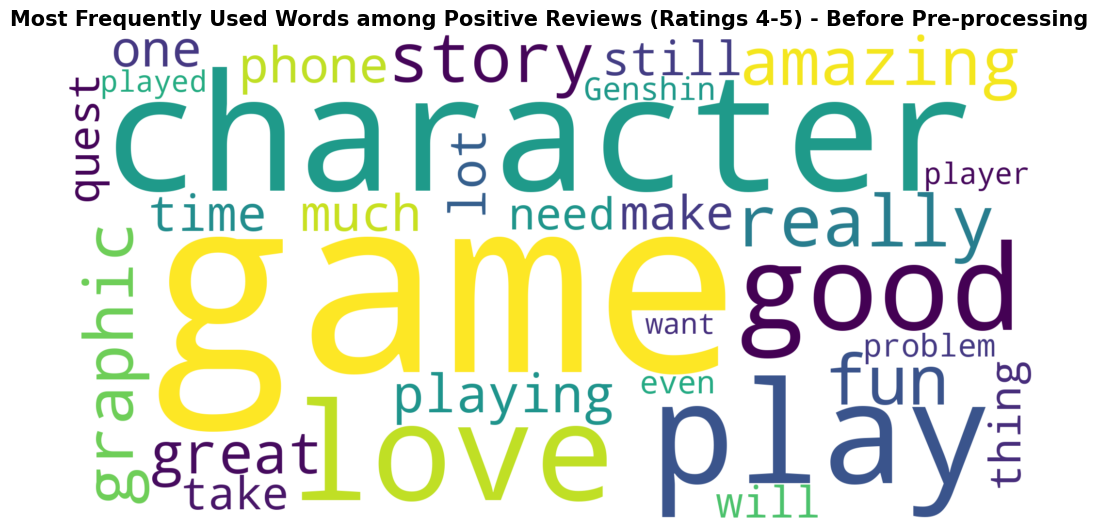

In [11]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(
    target=0,
    title='Most Frequently Used Words among Positive Reviews (Ratings 4-5) - Before Pre-processing',
    df=reviews,
    text_col_in_df='content',
    max_words=30,
)

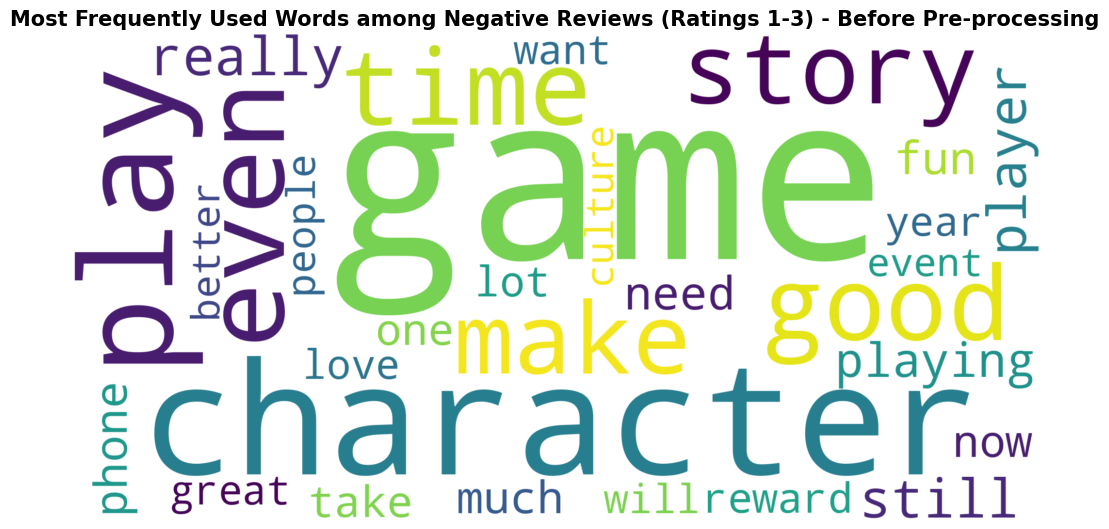

In [12]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(
    target=1,
    title='Most Frequently Used Words among Negative Reviews (Ratings 1-3) - Before Pre-processing',
    df=reviews,
    text_col_in_df='content',
    max_words=30,
)

Next, we will perform pre-processing to transform our text into a more digestible form for our classifier. The steps are as follows:
- Remove HTML tags
- Use regular expression to remove special characters and numbers
- Lowercase words
- Use NLTK to remove stopwords*
- Remove frequently occurring words that appear in both positive and negative sentiments, like 'character', 'game', 'play', 'really', etc. Some words like 'feel', 'like' & 'love' were added later on after we did a word cloud & uni/bi-gram analysis (in Section 2).
- Use NLTK to stem words to their root form. This is done to reduce the dimensionality in our text data.

For the purposes of data exploration, we will **refrain from lemmatizing our text.** But, when modelling later on, we will experiment and see which approach (yielding/lemmatizing) yields the highest accuracy/F1-score.

In [13]:
stopwords_list = [
    'character', 'characters', 'even', 'feel', 'fun', 'game', 'Genshin', 'genshin', 
    'good', 'great', 'like', 'lot', 'love', 'make', 'much', 'need', 'play', 'player', 
    'playing', 'played', 'really', 'still', 'story', 'take', 'want',
]

# Pre-process the raw text
reviews['content_stem'] = reviews['content'].map(lambda x: stem_text(raw_text=x, stopwords_list=stopwords_list))

/tmp/ipykernel_363698/300972406.py:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_text).get_text()


In [14]:
reviews.loc[0]['score']

1

In [15]:
# This is the original text of the first review in our dataset
reviews.loc[0]['content']

"Controller doesn't work. Game is unplayable. Touchscreen controls do now allow for dodging attacks or using skills. All you can do is spam normal attacks and hope the enemy dies before you do. Edit: I was told by support that this version of the game is not being developed. Don't bother downloading it and potentially wasting your time or data."

In [16]:
# This is how the text looks like after stemming
reviews.loc[0]['content_stem']

'control work unplay touchscreen control allow dodg attack use skill spam normal attack hope enemi die edit told support version develop bother download potenti wast time data'

#### 1.3 Remove reviews that do not have any meaningful words

After pre-processing, we notice that there are some reviews that do not have any meaningful words left. As these reviews largely consists of only emojis or non-English characters, these reviews returned blank fields after stemming. In other words, the length of these reviews after pre-processing, was 0. Given that these reviews will not add value to our model's training, we will remove them from our dataset.

In [17]:
# Find the number of meaningful words in each review
reviews['content_clean_len'] = reviews['content_stem'].str.split().map(len)

In [18]:
# There are 203 reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0].shape

(311, 16)

In [19]:
# View reviews that do not have any meaningful words
reviews[reviews['content_clean_len']==0]['content']

1054    نیلو میخوام نیلو بده به خدا پولی که ازین در می...
1129                                                👎👎👎👎👎
1133    Геншин это донатерская помойка, в которой Орор...
1153              زبان فارسی نداره حال نمیده متوجه نمیشید
1187                                                   그냥
                              ...                        
8832                                            Good game
8837                                    Its a good game👍👍
8839                                            Very good
8844                                                 Good
8848                                           Great Game
Name: content, Length: 311, dtype: object

In [20]:
# Drop these reviews that do not have any meaningful words
reviews = reviews.drop(reviews[reviews['content_clean_len']==0].index)

In [21]:
# Reindex the dataframe
reviews.reset_index(drop=True, inplace=True)

#### 1.4 Remove reviews that are non-English or gibberish

We have identified several reviews that were written in non-English or simply gibberish. As we would like to train and test our model with only English text, we will remove these reviews to reduce the noise in our dataset. To do this we employ [Meta's fasttext language identification model](facebook/fasttext-language-identification).

In [ ]:
# this is quite a big file ~1GB!
model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")

In [9]:
model_path

'/home/faiq0913/.cache/huggingface/hub/models--facebook--fasttext-language-identification/snapshots/3af127d4124fc58b75666f3594bb5143b9757e78/model.bin'

In [22]:
model_path = '/home/faiq0913/.cache/huggingface/hub/models--facebook--fasttext-language-identification/snapshots/3af127d4124fc58b75666f3594bb5143b9757e78/model.bin'

In [23]:
model = fasttext.load_model(model_path)

In [24]:
# take one sample
reviews.loc[666]['content']

"Complete and utter refusal to diversify their character base despite requests from players, voice actors, and even DEVS proves that they really have no interest in keeping their story culturally accurate and makes every 'attempt' to do so a sad charade of appropriation. Beauty and graphics don't matter when we don't have representation."

In [25]:
model.predict(reviews.loc[666]['content'])

(('__label__eng_Latn',), array([0.99969471]))

In [26]:
reviews['language'] = reviews['content'].map(lambda x: model.predict(x)[0][0])

In [27]:
reviews['language'].value_counts()

language
__label__eng_Latn    8091
__label__yue_Hant      77
__label__ind_Latn      51
__label__deu_Latn      37
__label__kor_Hang      35
                     ... 
__label__lua_Latn       1
__label__epo_Latn       1
__label__cat_Latn       1
__label__luo_Latn       1
__label__fin_Latn       1
Name: count, Length: 64, dtype: int64

A cursory glance yields that the **classification of English text isn't perfect** which may be due to in-game language nuances (which indicate a need for finetuning). Nonetheless, for the sake of time, we will proceed as is as manually looking for English texts would be too time consuming.

In [28]:
reviews.loc[~reviews['language'].str.contains('eng')]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id,target,content_stem,content_clean_len,language
205,68d434aa-109e-4fb0-8ec6-824a0e09f6d0,Ren Jie Leo,https://play-lh.googleusercontent.com/a-/ALV-U...,"For the very last time, STOP TELLING ME THERE ...",1,8,5.1.0_27118081_27297621,2024-10-20 11:21:37,"We sincerely apologize for this issue, Travele...",2024-10-21 17:36:45,5.1.0_27118081_27297621,most_relevant,com.miHoYo.GenshinImpact,1,last time stop tell data error code theat unin...,16,__label__yue_Hant
732,255d478e-4343-4308-b64a-b400bf862ac5,Fedora Mede,https://play-lh.googleusercontent.com/a-/ALV-U...,I'VE BEEN PLAYING GENSHIN FOR A VERY LONG TIME...,1,2,4.8.0_24603909_24822834,2024-07-24 04:25:53,NaN,NaT,4.8.0_24603909_24822834,most_relevant,com.miHoYo.GenshinImpact,1,long time would give five star rate recent get...,37,__label__yue_Hant
1004,3ad9be7a-6061-43ef-b3e4-95bad6d3a046,Eleni K,https://play-lh.googleusercontent.com/a-/ALV-U...,Boo,1,0,2.6.0_6179196_6305792,2024-11-02 06:27:16,NaN,NaT,2.6.0_6179196_6305792,newest,com.miHoYo.GenshinImpact,1,boo,1,__label__deu_Latn
1009,d0dfccf4-06fc-432b-91a9-ed42c4c4a068,Ricky Magtajas,https://play-lh.googleusercontent.com/a-/ALV-U...,GIVE US THE SKIP BUTTON!!!!!,1,0,NaN,2024-11-02 01:11:01,NaN,NaT,NaN,newest,com.miHoYo.GenshinImpact,1,give us skip button,4,__label__yue_Hant
1016,770b3c6e-e42e-4cc9-9888-cec072552256,Juan Basante,https://play-lh.googleusercontent.com/a-/ALV-U...,"Nada... Cero, materia oscura",1,0,NaN,2024-11-01 21:17:56,NaN,NaT,NaN,newest,com.miHoYo.GenshinImpact,1,nada cero materia oscura,4,__label__spa_Latn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8519,8597d264-26fe-46f6-bc90-7d5db5e293b3,alt acc,https://play-lh.googleusercontent.com/a-/ALV-U...,hm ya la very good lo hm ya very nice la graph...,5,0,NaN,2024-10-19 10:14:39,NaN,NaT,NaN,newest,com.miHoYo.GenshinImpact,0,hm ya la lo hm ya nice la graphic ok ah ah oka...,15,__label__som_Latn
8529,02bb08f0-3eea-45f5-aea3-90d86b394613,Rameshwar,https://play-lh.googleusercontent.com/a-/ALV-U...,BEST GRAPHICS I LIKE THIS GAME VERY MUCH,5,0,5.1.0_27118081_27297621,2024-10-19 02:41:04,NaN,NaT,5.1.0_27118081_27297621,newest,com.miHoYo.GenshinImpact,0,best graphic,2,__label__yue_Hant
8532,f5e1c867-a7d1-4b1d-922e-ee87824e0479,Kathleen,https://play-lh.googleusercontent.com/a-/ALV-U...,NO WORDS. JUST DOWNLOAD IT RN!! ITS THE BEST!!...,5,0,5.1.0_27118081_27297621,2024-10-19 00:54:27,NaN,NaT,5.1.0_27118081_27297621,newest,com.miHoYo.GenshinImpact,0,word download rn best,4,__label__yue_Hant
8534,4c5af648-57bb-482c-a895-e203159b1606,Mohd Fazdley,https://play-lh.googleusercontent.com/a/ACg8oc...,genshin bukan game kikir ges,5,0,5.1.0_27118081_27297621,2024-10-19 00:51:16,NaN,NaT,5.1.0_27118081_27297621,newest,com.miHoYo.GenshinImpact,0,bukan kikir ge,3,__label__ind_Latn


In [29]:
reviews_cleaned = reviews.loc[reviews['language'].str.contains('eng')]

reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8091 entries, 0 to 8537
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              8091 non-null   object        
 1   userName              8091 non-null   object        
 2   userImage             8091 non-null   object        
 3   content               8091 non-null   object        
 4   score                 8091 non-null   int64         
 5   thumbsUpCount         8091 non-null   int64         
 6   reviewCreatedVersion  5911 non-null   object        
 7   at                    8091 non-null   datetime64[ns]
 8   replyContent          1041 non-null   object        
 9   repliedAt             1041 non-null   datetime64[ns]
 10  appVersion            5911 non-null   object        
 11  sort_order            8091 non-null   object        
 12  app_id                8091 non-null   object        
 13  target                8

In [30]:
reviews_cleaned.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sort_order,app_id,target,content_stem,content_clean_len,language
0,9ebbaa68-df60-45ce-bd37-634ed84c4246,Konuchi A,https://play-lh.googleusercontent.com/a-/ALV-U...,Controller doesn't work. Game is unplayable. T...,1,15,5.0.0_26041933_26161852,2024-11-01 18:13:52,We sincerely apologize for your unsatisfactory...,2024-10-22 14:15:18,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1,control work unplay touchscreen control allow ...,27,__label__eng_Latn
1,12b832b8-a76a-4292-a916-cbda39384153,BAI Li,https://play-lh.googleusercontent.com/a-/ALV-U...,I've been playing this game for about two year...,1,539,5.0.0_26041933_26161852,2024-09-29 18:04:07,We sincerely apologize for your unsatisfactory...,2024-09-30 16:43:34,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1,two year stun graphic well develop plot except...,43,__label__eng_Latn
2,7f339f1c-a3ac-46ab-95b1-7a2991476824,Tahlia Tucker,https://play-lh.googleusercontent.com/a-/ALV-U...,The rating I could just give is a 1 since I ca...,1,23,5.0.0_26041933_26161852,2024-09-19 06:09:10,We sincerely apologize for your unsatisfactory...,2024-09-25 19:04:25,5.0.0_26041933_26161852,most_relevant,com.miHoYo.GenshinImpact,1,rate could give sinc get instal get download r...,28,__label__eng_Latn


#### 1.5 Create a train and test set

20% of the original dataset will be set aside and used as a test set. This will be useful in evaluating our model's performance on unseen data.

We will use stratification to preserve the class representation in our train and test set.

In [31]:
# As we would like to stratify our target variable, we will need to first assign X and y
X = reviews_cleaned[[cols for cols in reviews_cleaned.columns if cols != 'target']]
y = reviews_cleaned['target']

In [32]:
# Perform a train_test_split to create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# Merge X_train and y_train back together using index
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

# Merge X_test and y_test back together using index
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [34]:
# Reindex the train and test set
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
# 6472 documents in our training set
train.shape

(6472, 17)

In [ ]:
# 1619 documents in our training set
test.shape

(1619, 17)

In [37]:
# Check split in class labels for training set
train['target'].value_counts(normalize=True)

target
1    0.601978
0    0.398022
Name: proportion, dtype: float64

In [38]:
# Check split in class labels for validation set
test['target'].value_counts(normalize=True)

target
1    0.601606
0    0.398394
Name: proportion, dtype: float64

Finally, after data cleaning, we now have 6472 reviews for training and 1619 reviews in our test set. The class representation is consistent across the train and test set, with 39.8~% of the data belonging to class 0 (positive sentiment) and 60.2~% belonging to class 1 (negative sentiment).

### 2.0 Exploratory Data Analysis

We will perform EDA to draw insights from our training set. This step is also crucial in helping us determine if any more pre-processing is necessary before training the model.

#### 2.1 Wordclouds: Most frequently used words (after pre-processing)

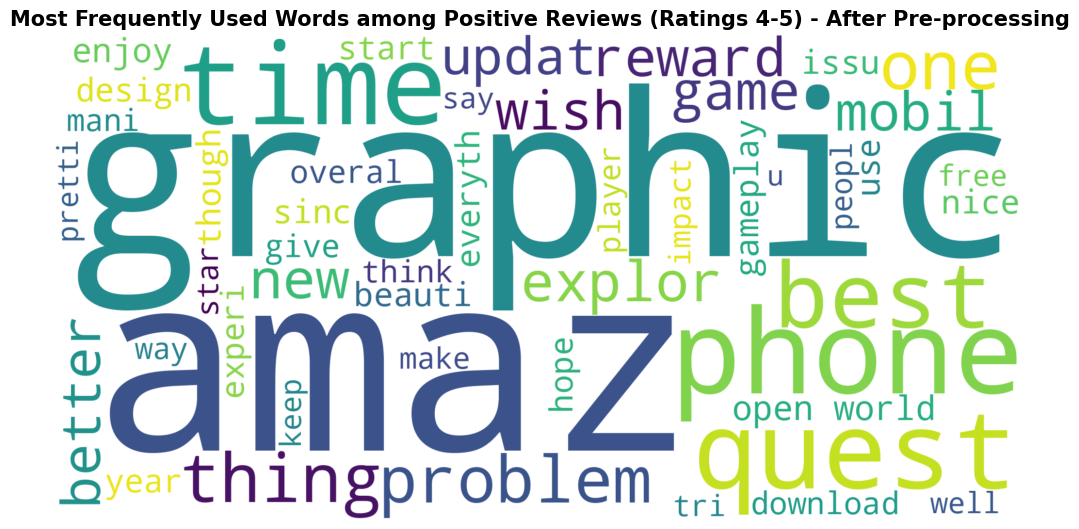

In [39]:
# Wordcloud of the 50 most frequently occurring words among positive reviews
plot_wordcloud(
    target=0,
    title='Most Frequently Used Words among Positive Reviews (Ratings 4-5) - After Pre-processing',
    df=reviews_cleaned,
    text_col_in_df='content_stem',
    max_words=50,
)

The words 'graphic' and 'amaz' (amazing) are the most frequently seen words among reviews with positive sentiment.

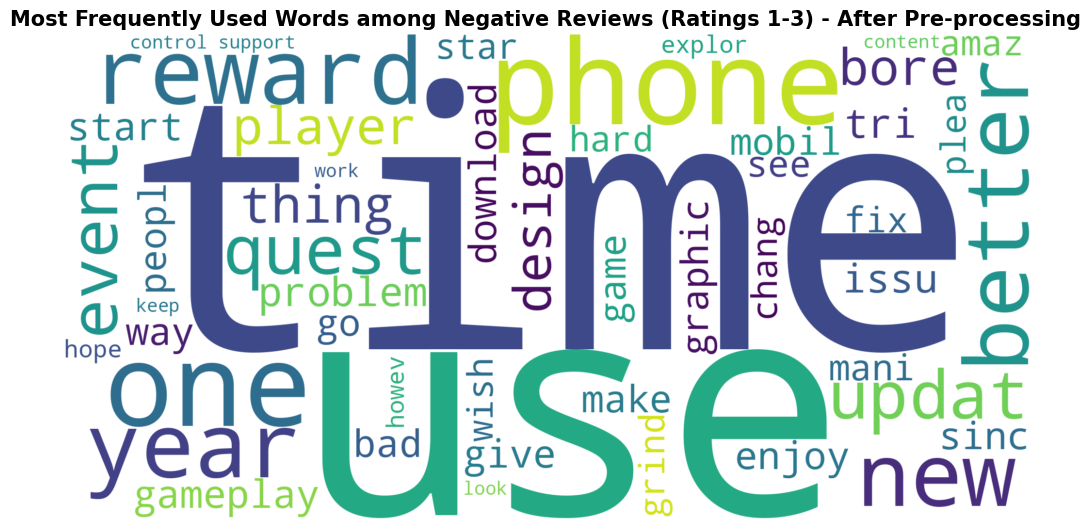

In [40]:
# Wordcloud of the 50 most frequently occurring words among negative reviews
plot_wordcloud(
    target=1,
    title='Most Frequently Used Words among Negative Reviews (Ratings 1-3) - After Pre-processing',
    df=reviews_cleaned,
    text_col_in_df='content_stem',
    max_words=50,
)

The words 'use' and 'time' are the most frequently seen words among reviews with negative sentiment.

#### 2.2 Top uni-grams and bi-grams

We will use CountVectorizer to tokenize our textual data and generate bar plots for the top uni-grams and bi-grams seen in each sentiment. Are there unique words that will help us to distinguish between positive and negative sentiments? Or, are there certain words that are occurring in both sentiments?

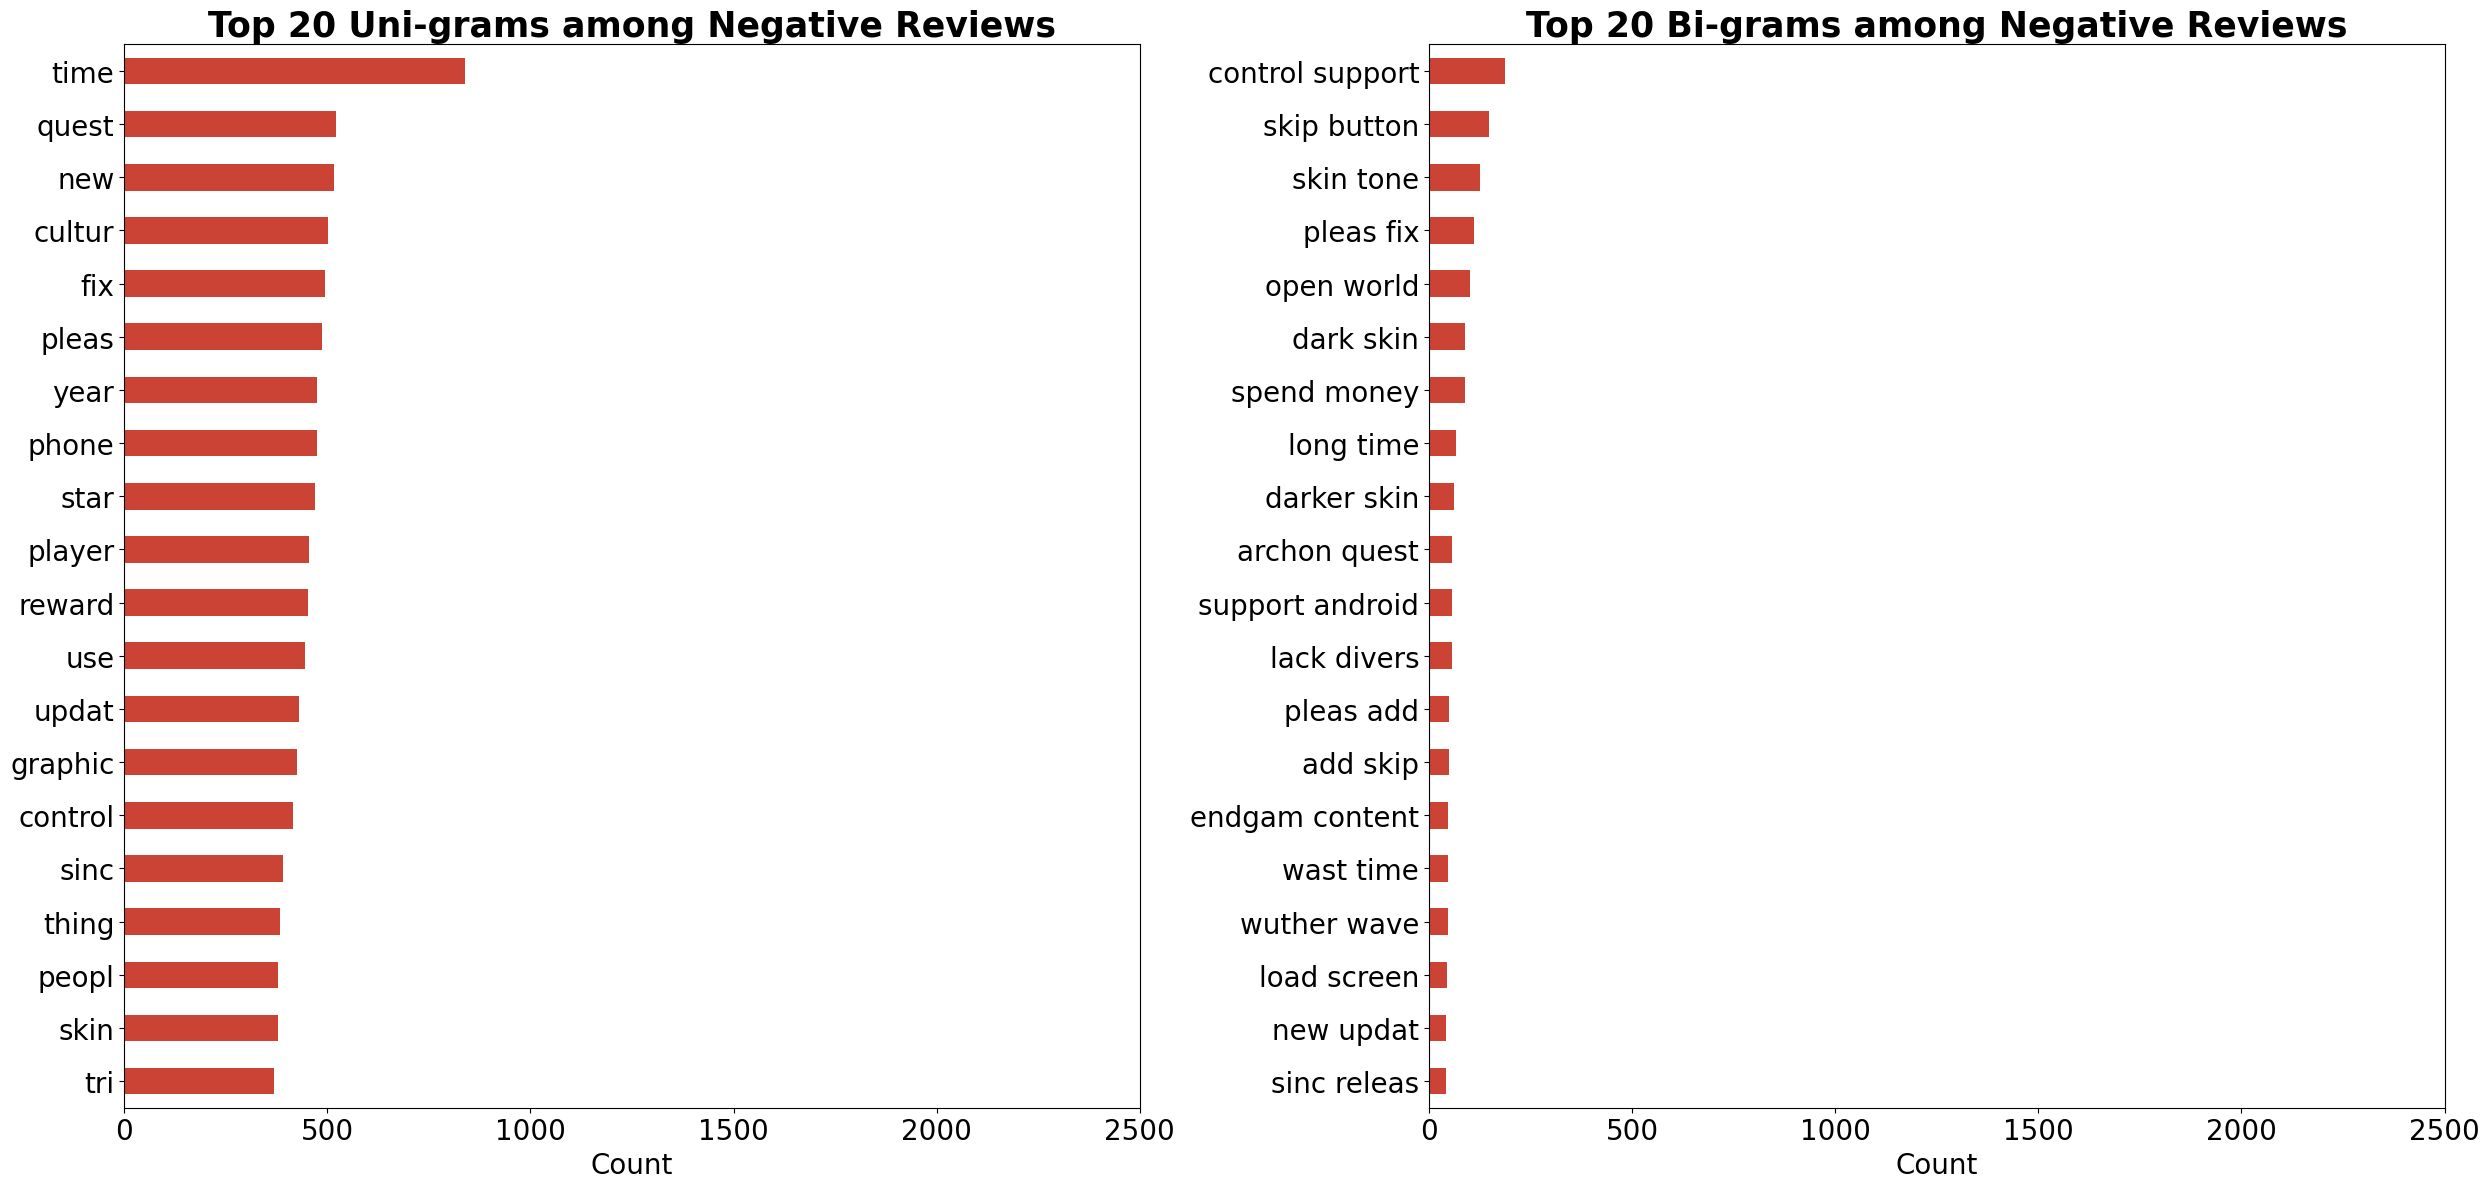

In [41]:
# Plot the uni-grams and bi-grams for negative reviews
barplot_cvec(
    df=train,
    target=1,
    titles=['Top 20 Uni-grams among Negative Reviews','Top 20 Bi-grams among Negative Reviews'], 
    color='#CB4335',
    xlimit=(0,2500)
)

The top bi-grams are requests for better controller support and a skip button. Genshin's stories are notoriously long and dense with plot and dialogue so for more action-oriented gamers, they may want a skip button. Moreover, this also clues us in that Genshin's controller support ought (on mobile mostly e.g., Android) should be developed.

Another interesting bi-gram are the diversity related complaints e.g., 'lack divers', 'dark skin', 'skin tone'. These set of complaints likely reference the Natlan update (the most recently released region as of 3rd November 2024). While drawing inspiration from Mesoamerican cultures and Native American cultures, the majority of characters are rather light-skinned contrary to their real life origins. This is another critique Hoyoverse should keep in mind when releasing new characters.

'time' and 'quest' also in the top 3 most frequently occurring uni-grams in negative reviews. This reinforces the notion that users are somewhat dissatisfied with the long/tedious quest lines (at least for those who give the game a negative review).

In [43]:
# Showing some of the negative reviews with the bi-gram 'control support'
train[(train['target']==1) & (train['content_stem'].str.contains('control support'))][['content','score']].head(10)

,content,score
19,probably a great game but no controller suppor...,1
179,Please add controller support for android! It'...,1
203,"No controller support, and wuthering waves has...",1
226,Nearing four years since its release yet there...,3
290,Plz add controller support for Android,2
316,Genshin is already 4 year still no controller ...,1
331,no native controller support,3
334,Needs Controller support!!! This is a great ga...,3
354,still no controller support for android and PC...,1
414,Very fun on PC. Unplayable on mobile. I can't ...,1


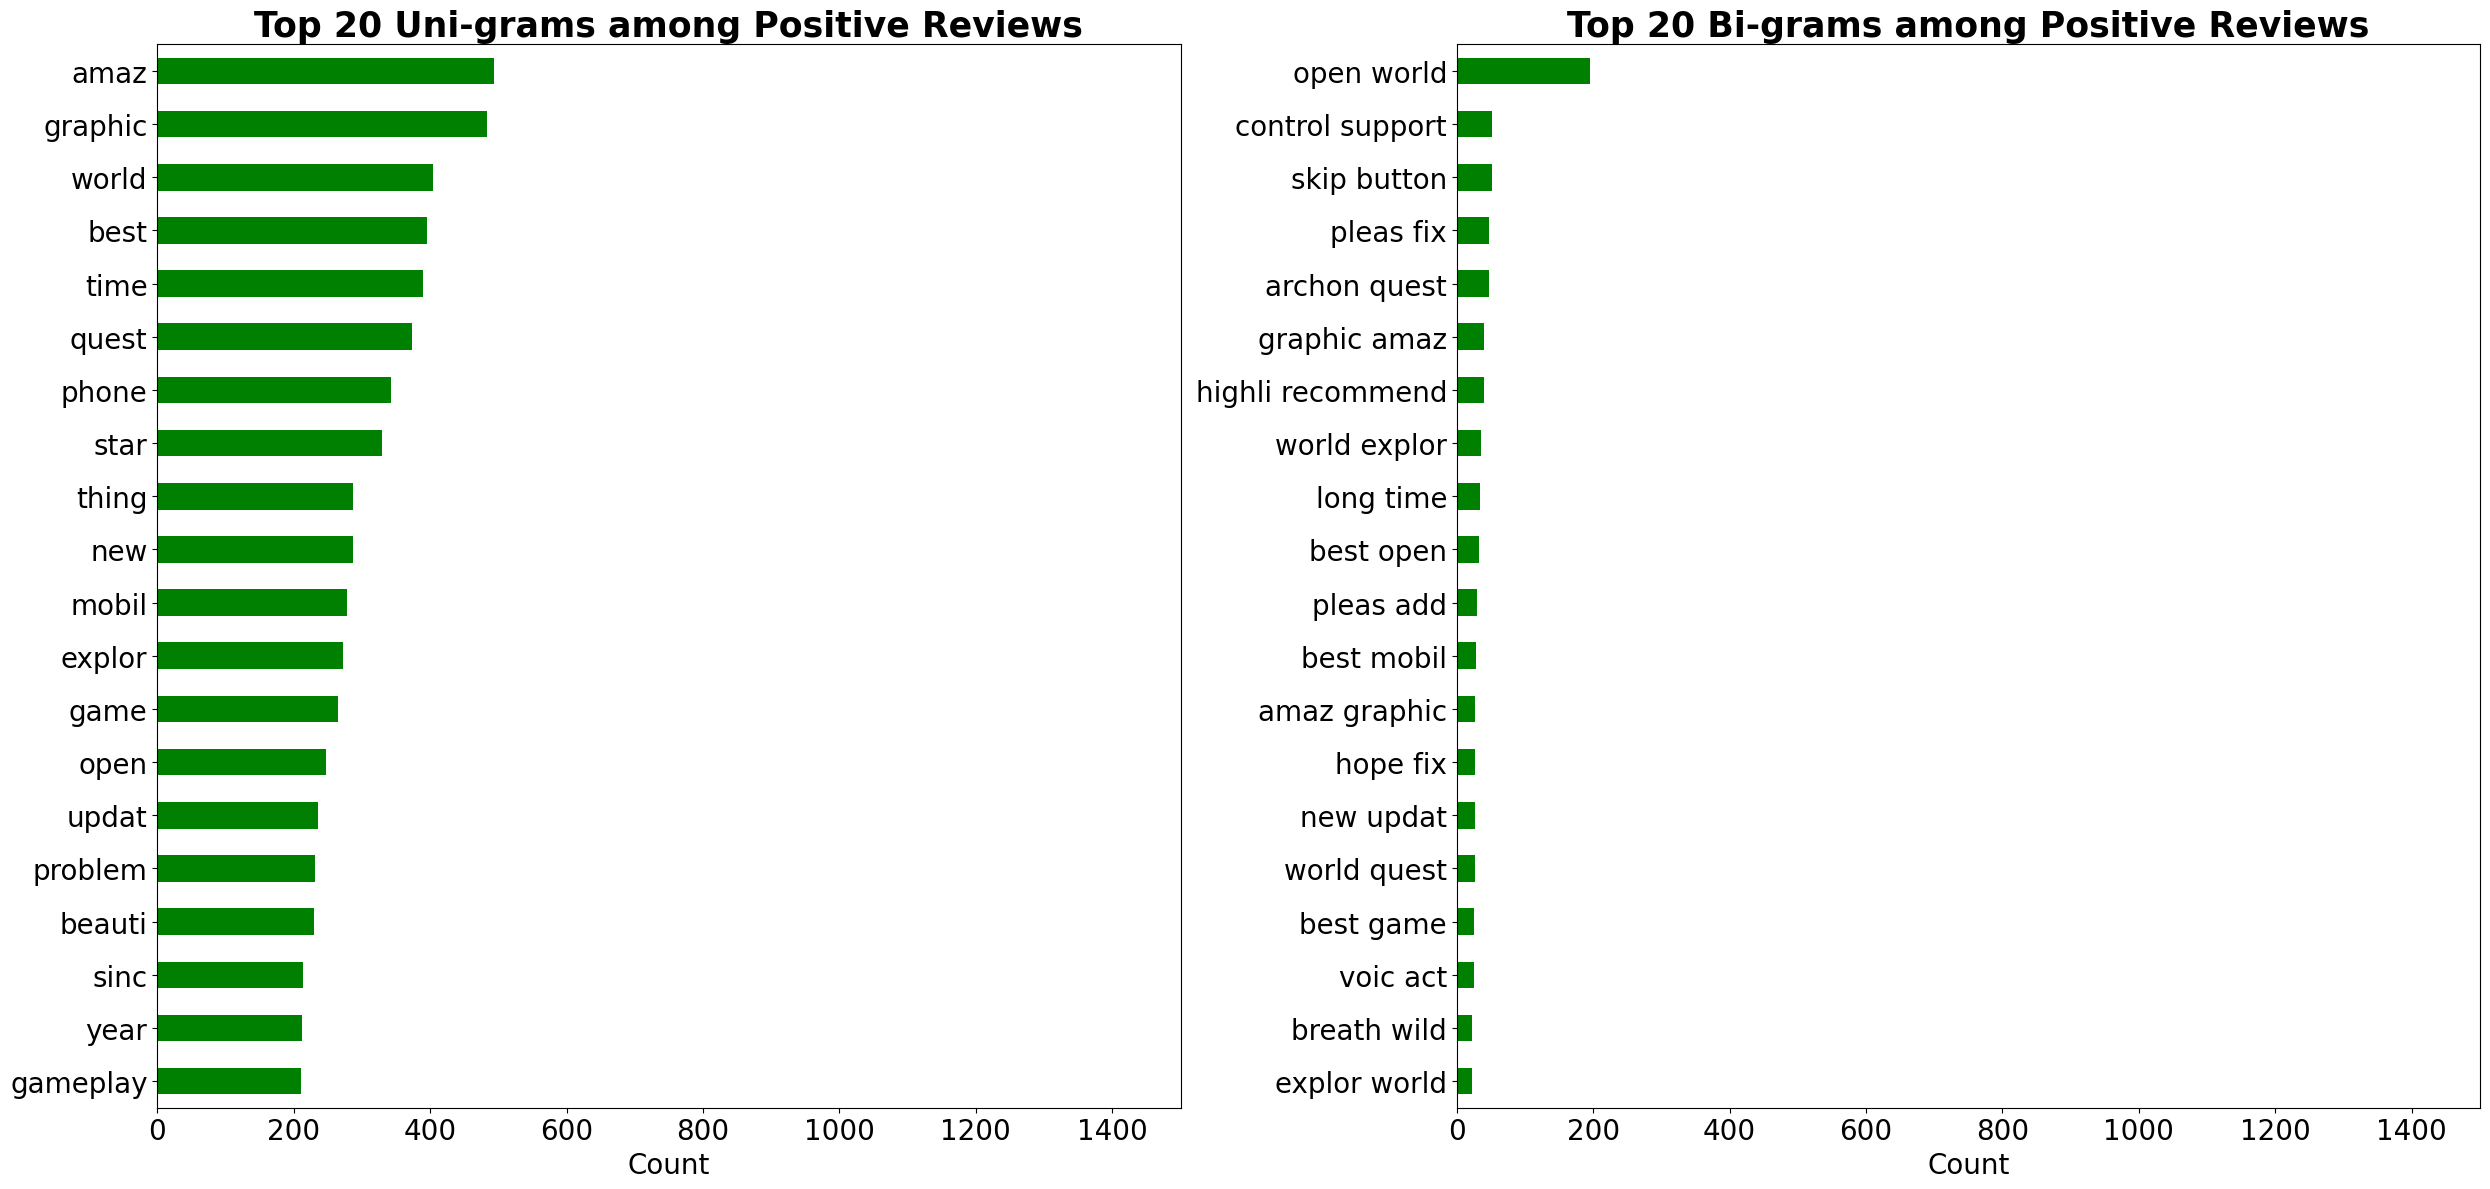

In [61]:
# Plot the uni-grams and bi-grams for positive reviews
barplot_cvec(
    df=train,
    target=0,
    titles=['Top 20 Uni-grams among Positive Reviews','Top 20 Bi-grams among Positive Reviews'], 
    color='#008000',
    xlimit=(0,1500)
)

'amaz', 'world' and 'graphic' are the top 3 most frequently seen uni-grams in positive reviews. The bi-grams (where 'open world' comes out on top) reinforce the notion that Genshin Impact's core strength is the immersive world and graphics their developer team has helped craft. However, we do see a lot complaints (similar to the negative review bi-grams) appear very high as well. This lets us know that while there's widespread appeal for the game, its not without its flaws.

In [62]:
# Showing some of the positive reviews with the bi-gram 'open world'
train[(train['target']==0) & (train['content_stem'].str.contains('open world'))][['content','score']].head(10)

,content,score
8,Best game ever It is really nice of a open wor...,5
72,Best Open World Gacha I've played and HoYo has...,5
156,This game is very fun and the open world and m...,4
181,"This is the best open world game, I played til...",5
242,Genshin Impact is a visual and gameplay marvel...,5
320,All in all a well rounded game. Though graphic...,4
324,"It's a great game, open world, cool combat, fu...",4
338,"Amazing game, love how it's a beautiful open w...",4
357,Got the game on Launch for the PC. Love the ga...,4
372,I've been playing this game for about a year n...,5


#### 2.3 Number of meaningful words

Let's now compare the length of the reviews among positive vs negative sentiments.

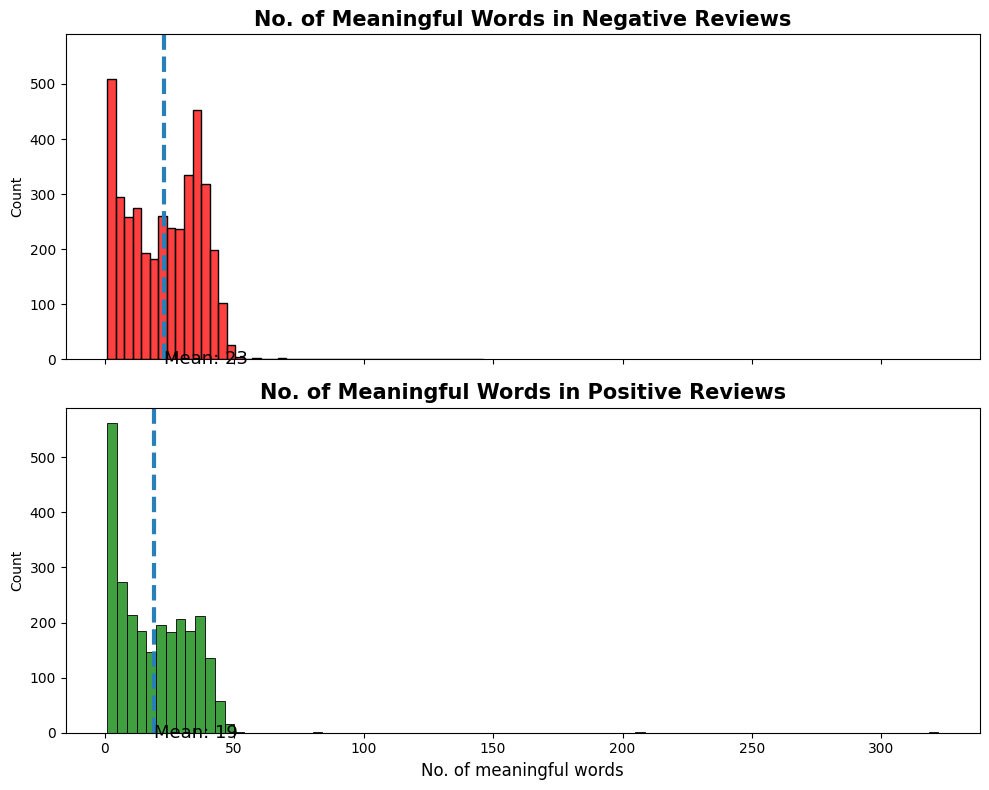

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)

# Plots the distribution of the length of negative reviews
neg_len = train[train['target']==1]['content_clean_len']
sns.histplot(neg_len, color='red', ax=ax[0])
ax[0].axvline(neg_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[0].text(
    x=neg_len.mean(),
    y=0.08,
    s=f'Mean: {round(neg_len.mean())}', 
    horizontalalignment='left', 
    verticalalignment='center',
    fontsize=13,
)
ax[0].set_title('No. of Meaningful Words in Negative Reviews', fontsize=15, fontweight='bold')
ax[0].set_xlabel('No. of meaningful words', size=12)

# Plots the distribution of the length of positive reviews
pos_len = train[train['target']==0]['content_clean_len']
sns.histplot(pos_len, color='green', ax=ax[1])
ax[1].axvline(pos_len.mean(), linestyle='dashed', linewidth=3, c='#2980B9') # Plot the mean line
ax[1].text(
    x=pos_len.mean(),
    y=0.08,
    s=f'Mean: {round(pos_len.mean())}', 
    horizontalalignment='left', 
    verticalalignment='center',
    fontsize=13,
)
ax[1].set_title('No. of Meaningful Words in Positive Reviews', fontsize=15, fontweight='bold')
ax[1].set_xlabel('No. of meaningful words', size=12)
plt.tight_layout()

**Both distributions are bi-modal** (moreso for the negative reviews), with only a small proportion of posts that have > 30 meaningful words. In fact, 26~% of positive reviews and 37~% of negative reviews have more than 30 meaningful words. The average number of meaningful words in a negative review (19 words) is slightly higher than that in a positive review (23 words). Overall, this suggests that dissatisfied players are more likely to write slightly longer reviews.

In [54]:
# Number of reviews that had > 30 meaningful words
train[train['content_clean_len'] > 30]['target'].value_counts().sort_index()

target
0     672
1    1447
Name: count, dtype: int64

In [63]:
train.target.value_counts()

target
1    3896
0    2576
Name: count, dtype: int64

In [ ]:
# 26% of positive reviews have > 30 meaningful words
672/2576

0.2608695652173913

In [ ]:
# 37% negative reviews have > 30 meaningful words
1447/3896

0.3714065708418891

#### 2.4 Time frame of the reviews written

We will compare the distributions of the review dates across various ratings, 1-5.

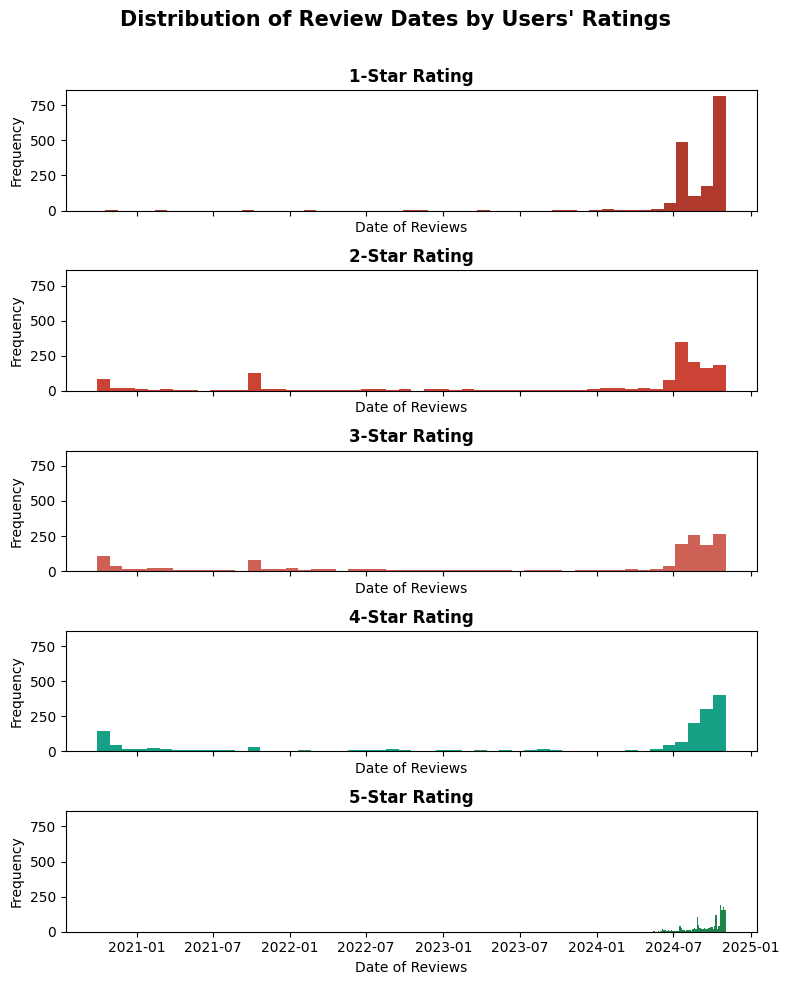

In [58]:
subplot_histograms(
    df=reviews_cleaned,
    main_title="Distribution of Review Dates by Users' Ratings",
    list_of_titles=['1-Star Rating','2-Star Rating','3-Star Rating','4-Star Rating','5-Star Rating'], 
    xlabels='Date of Reviews',
    list_of_colors = ['#B03A2E','#CB4335','#CD6155','#16A085','#1E8449']
)

The distributions of review dates differ across various rating scores (moreso for 5-Star ratings). While the data collected for 5-star ratings are all dated in the year 2024 (which is due to Genshin's widespread appeal), reviews with other ratings are dated back to 2021 (near the game's launch, 28th September 2020). In an ideal world, we would like the reviews for each rating score to be collected in equal quantities, over the same time period. However, given that the majority of users gave the game a 5-Star rating, the data collection for negative reviews had to go back further in time. This was to obtain a balanced class training set, consisting of a relatively equal split between positive and negative reviews.

#### 2.5 Number of thumbs up received

Users can show their approval by giving a "thumbs up" to reviews on Genshin Impact's app. A higher number of thumbs up received from the community will suggest that several others have also been experiencing the same issues.

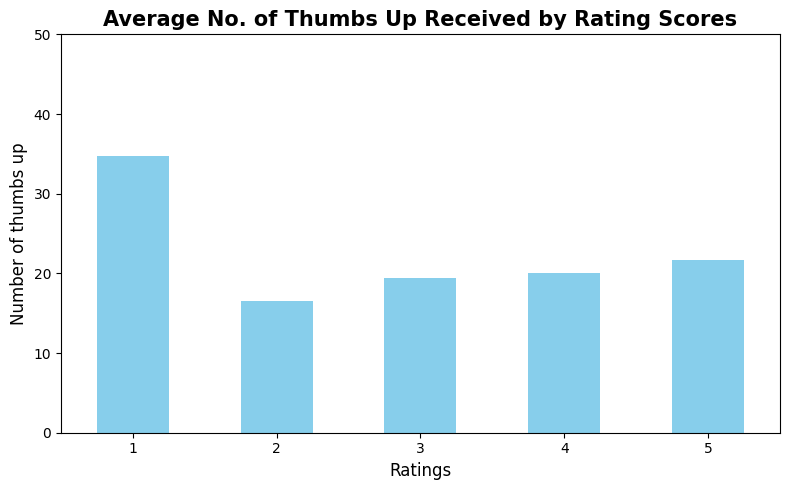

In [59]:
# Group by rating scores and find the average no. of thumbs up per score
train.groupby('score')['thumbsUpCount'].mean().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel('Ratings', fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('Number of thumbs up', fontsize=12)
plt.ylim(0,50)
plt.title('Average No. of Thumbs Up Received by Rating Scores', fontsize=15, weight='bold')
plt.tight_layout()

Negative reviews with 1-Star ratings receive more thumbs up on average. This is likely due to widespread consensus of Genshin Impact's flaws across the community. We'll see if we can quantify this later on.

In [60]:
# Show the top 5 reviews that received the highest number of thumbs up
train[['content','thumbsUpCount','score']].sort_values(by='thumbsUpCount', ascending=False).head()

,content,thumbsUpCount,score
5609,"Exploration is good, characters and weapons ar...",4519,1
2015,For years now we have begged for a skip dialog...,3875,1
151,The game forces you to sit through extremely l...,3154,2
5372,Been playing for 2 years and I've tried genshi...,2948,5
6119,The Best game i ever had and it will always ha...,2942,4


### 3.0 Save clean datasets for modeling & Next Steps

In [64]:
# Keep only the columns that we need for modeling and interpretation
train = train[['content','content_stem','score','target']]
test = test[['content','content_stem','score','target']]

In [65]:
# Save clean training set
train.to_csv('../data/clean_train_stem.csv', index=False)

In [66]:
# Save clean test set
test.to_csv('../data/clean_test_stem.csv', index=False)

We'll also create a train-test-split where we employ lemmatization. This will help us test which approach works best.